In [35]:
import numpy as np
from parcels import FieldSet, ParticleSet, ScipyParticle, JITParticle, ErrorCode, AdvectionRK4, Variable
from datetime import timedelta
from datetime import datetime
import netCDF4 as netcdf
import matplotlib.pyplot as plt
import matplotlib as mpl
import cartopy
import cartopy.crs as ccrs
from timeit import default_timer as timer
import glob
import os

print("This cell is complete")

This cell is complete


In [36]:
# plotting parameters
mpl.rcParams['font.size'] = 14
mpl.rcParams['font.weight'] = 'normal'

mpl.rcParams["figure.figsize"] = [8 , 4]
mpl.rcParams['legend.fontsize'] = 12      #legend size
#title params
mpl.rcParams['axes.titlesize'] = 20
mpl.rcParams['axes.titleweight'] = 'bold'
mpl.rcParams['font.style'] = 'italic'    #all fonts italic
#axes params
mpl.rcParams['axes.labelsize'] = 16
mpl.rcParams["xtick.labelsize"] = 13
mpl.rcParams["ytick.labelsize"] = 13
# line width and grid
mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams["axes.grid"] = 1
# mpl.rcParams["figure.subplot.left"] = 0.05
# mpl.rcParams["figure.subplot.right"] = 0.1
# mpl.rcParams["figure.subplot.bottom"] = 0.11
mpl.rcParams["savefig.bbox"] = 'tight'
mpl.rcParams["savefig.pad_inches"] = 0.1
mpl.rcParams['legend.loc'] =  'best'
    


In [37]:
datadir = '/data2/imau/oceanparcels/hydrodynamic_data/NEMO-MEDUSA/ORCA0083-N006/means/' #Directory for nemo data
outputdir = '/scratch/AnnekeV/output/' #Directory for output files

print("This cell is complete")

This cell is complete


# Functions

In [38]:
'''Kernels'''
def DeleteParticle(particle, fieldset, time, dt):
    """Kernel for deleting particles if they are out of bounds."""
    particle.delete()

def periodicBC(particle, fieldset, time, dt):
    """
    Kernel for periodic boundaries in longitude, not sure if this is correct
    """
    if particle.lon < 0.:
        particle.lon += 360.
    elif particle.lon > 360.:
        particle.lon -= 360.

def Sample_sit(particle, fieldset, time, dt):  # Custom function that samples fieldset.P at particle location
    """
    Kernel for attributing sea ice thickness to a particle
    """
    particle.sit = fieldset.sit[time, particle.lon, particle.lat, particle.depth]
    particle.sip = fieldset.sip[time, particle.lon, particle.lat, particle.depth]
    
    
print("This cell is complete")

This cell is complete


In [24]:
def plot_output(file_dir, dt_days = 5, y_extent = 65):
    '''
    plot the trajectories of particles on a map
    file_dir = the file with the trajectories
    y_extent = the extent of the map
    '''

    test = netcdf.Dataset(file_dir + ".nc")
    lat = test['lat'][:,:]
    lon  = test['lon'][:,:]
    test.close()
    
    n_days = int((np.size(lat,1))*dt_days)
    n_part = np.size(lat,0)
    colors = colors_peeken
    
    plt.figure(figsize = [8,8])
    ax = plt.axes(projection=ccrs.NorthPolarStereo())
    ax.gridlines(xlocs = np.arange(-180,185,20), ylocs = np.arange(0, 95,5))
    ax.set_global()

    for i in range(n_part):
        plt.scatter(lon[i,:], lat[i,:],
                 marker='o',
                 linewidth = 1,
                 transform=ccrs.PlateCarree(),
                 s = 15,
                 color = colors[i]
                 )
        
    
        plt.plot(lon[i,0], lat[i,0],
                 color=colors[i], 
                 transform=ccrs.PlateCarree(),
                 marker= 'X',
                 label = "{:.2f},{:.2f}".format(lat[i,0], lon[i,0]),
                 markersize = 17,
                 linestyle = 'None'
                 )
    plt.legend()
    ax.add_feature(cartopy.feature.OCEAN)
    ax.add_feature(cartopy.feature.LAND)

    ax.set_extent([-180,180,y_extent,90],ccrs.PlateCarree())
    plt.title("Simulation for {} days ".format(n_days))

print("This cell is complete")

This cell is complete


In [25]:
def plot_single_variable(f_part, variable_name, dt_days = 5 , gradient = False  ):
    '''Plot a variable against time
    f_part = file with the trajectories of particles
    variable_name = the desired variable'''
    
    DAY = 24*3600

    f_adv  = netcdf.Dataset(f_part)    # file containing advected particles
    lat    = f_adv['lat'][:,:]
    lon    = f_adv['lon'][:,:]
    var    = f_adv[variable_name][:,:]
    time   = f_adv['time'][:,:]
    f_adv.close()
        
    n_part = int(np.size(var,0))        # number of particles
    n_sampling_points = np.size(var,1)  # number of output points
    n_days = n_sampling_points*dt_days  # number of days


        
    plt.figure()
    plt.xlabel("Time (days)")
    plt.ylabel(variable_name) 
    plt.title(variable_name)
    plt.xticks(rotation=45)
    for i in range(n_part):  
        plt.plot(time[i,:]/DAY,var[i,:], color = colors_peeken[i] )  

    


In [39]:
fileList = list(np.sort(glob.glob(os.path.join(datadir , '*2005*d05I.nc'))))

## Fieldset

In [40]:
'''Fieldset'''

start = timer()



filenames = {'U': {'lon':  datadir + "ORCA0083-N06_20090813d05U.nc",
                   'lat':  datadir + "ORCA0083-N06_20090813d05U.nc",
                   'data': fileList},
             'V': {'lon':  datadir + "ORCA0083-N06_20090813d05U.nc",
                   'lat':  datadir + "ORCA0083-N06_20090813d05U.nc",
                   'data': fileList},
             'sit':{'lon': datadir + "ORCA0083-N06_20090813d05U.nc",
                   'lat':  datadir + "ORCA0083-N06_20090813d05U.nc",
                   'data': fileList}, 
             'sip':{'lon': datadir + "ORCA0083-N06_20090813d05U.nc",
                   'lat':  datadir + "ORCA0083-N06_20090813d05U.nc",
                   'data': fileList}  
            }

variables = {'U': 'uice_ipa',
             'V': 'vice_ipa',
             'sit': 'sit'  ,
             'sip':'sip'
            
            }

dimensions = {'lat'  : 'nav_lat',
              'lon'  : 'nav_lon',
              'time' : 'time_counter'
              }

fieldset = FieldSet.from_nemo(filenames, variables, dimensions, allow_time_extrapolation=False)

end = timer()
print("Time elapsed {:.1f} s".format(end-start))

Time elapsed 19.1 s


In [41]:
'''Latitude and longitude from peeken''' 

coordinates = np.loadtxt("thesis/data/peeken_table1.txt", skiprows = 1)
lat_peeken  = coordinates[:,0]
lon_peeken  = coordinates[:,1]
colors_peeken = ['blue', 'red', 'yellow', 'green', 'orange', 'pink', 'purple', 'turquoise', 'lightblue']


'''Pick last three since they were measured in 2005, hence in a time slot that we can calculate stuff with'''
lat_peeken    = lat_peeken[-3:]
lon_peeken    = lon_peeken[-3:]
colors_peeken = colors_peeken[-3:]

## Particle set

In [42]:
'''Particle set'''

start = timer()
n_part  = len(lat_peeken)


time = [np.datetime64('2005-08-29'), np.datetime64('2005-08-18'), np.datetime64('2005-09-19')]

class SampleParticle(JITParticle):               # Define a new particle class
    sit = Variable('sit', initial=fieldset.sit)  # Variable 'p' initialised by sampling the pressure
    sip = Variable('sip', initial=fieldset.sip)  



pset = ParticleSet.from_list(fieldset, 
                             pclass = SampleParticle, 
                             time=time,
                             lon=lon_peeken, 
                             lat=lat_peeken
                            )

end = timer()
print("Time elapsed {:.1f} s".format(end-start))


Time elapsed 23.3 s


# Execute
## normal rk4

INFO: Compiled SampleParticleperiodicBCSample_sitAdvectionRK4 ==> /tmp/parcels-26525/110cb0d9b980f8b26b15bdc41ae2e3c3.so
100% (4320000.0 of 4320000.0) |##########| Elapsed Time: 0:00:16 Time:  0:00:16


Time elapsed = 36.4 s


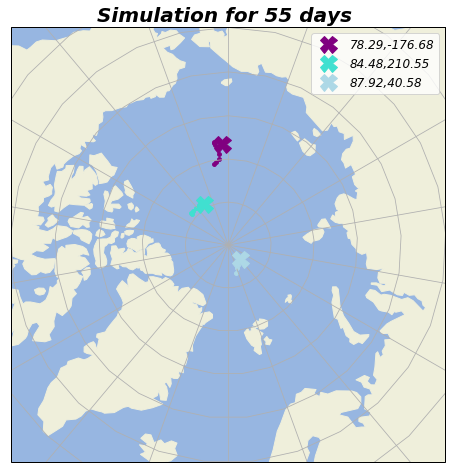

In [43]:
start = timer()

simdays = 50

outname   = "testuvdec_normalrk4"
outfile = outputdir + outname +  '_simdays_{:d}_npart_{:d}_pos_{:d}'.format(
            simdays, n_part, int(lat_peeken[0])) + '_bwd'
kernels= pset.Kernel(periodicBC) +pset.Kernel(Sample_sit) +  pset.Kernel(AdvectionRK4)


pset.execute(kernels, 
             runtime     = timedelta(days=simdays), 
             dt          = timedelta(minutes=10), 
             output_file = pset.ParticleFile(name=outfile, outputdt=timedelta(days=5)),recovery={ErrorCode.ErrorOutOfBounds: DeleteParticle})


end = timer()
print("Time elapsed = {:.1f} s".format(end-start))

plot_output(outfile, y_extent = 65)


# Figures

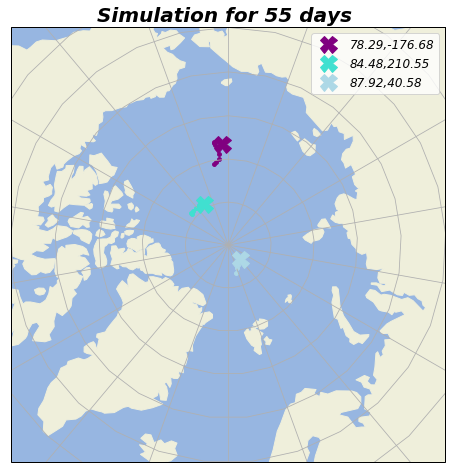

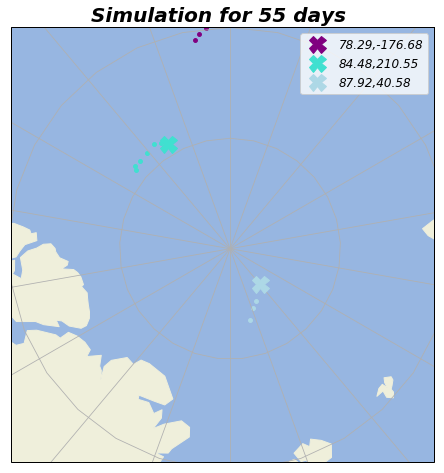

In [44]:
plot_output(outfile, y_extent = 65)
plot_output(outfile, y_extent = 80)

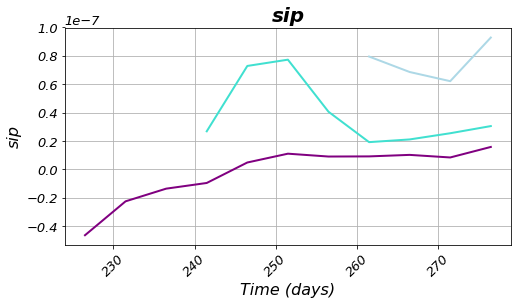

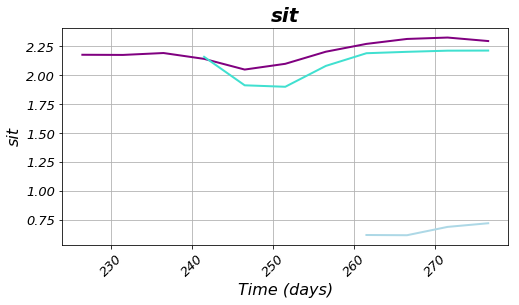

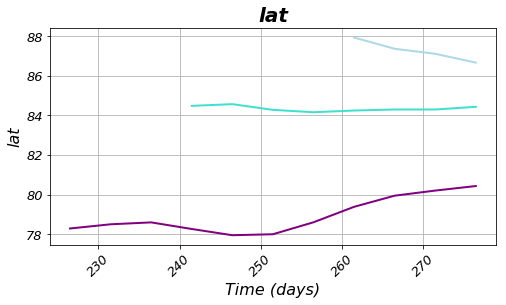

In [32]:
plot_single_variable(outfile+ ".nc", 'sip')

plot_single_variable(outfile+ ".nc", 'sit')

plot_single_variable(outfile+ ".nc", 'lat')

Some notes/try outs

<type 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    feature_type: trajectory
    Conventions: CF-1.6/CF-1.7
    ncei_template_version: NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_version: 1.1.1
    parcels_mesh: spherical
    dimensions(sizes): obs(11), traj(3)
    variables(dimensions): int32 trajectory(traj,obs), float64 time(traj,obs), float32 lat(traj,obs), float32 lon(traj,obs), float32 z(traj,obs), float32 sip(traj,obs), float32 sit(traj,obs)
    groups: 



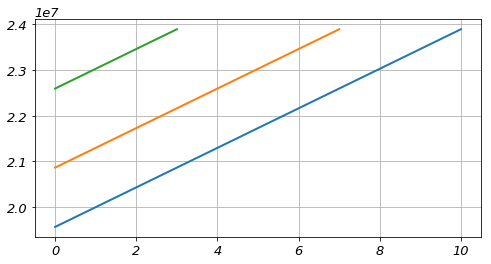

In [33]:

f_adv  = netcdf.Dataset(outfile + ".nc")    # file containing advected particles
print(f_adv)
for i in range(3):
    plt.plot(f_adv['time'][i,:])
f_adv.close()